# OGCM radiocarbon bias correction <br><br> Brief User Guide

This Jupyter Notebook covers a short demonstration of the bias correction method for radiocarbon ($\Delta^{14}$C) data in ocean general circulation models (OGCMs). The OGCM used here is the National Center for Atmospheric Research Community Climate System Model version 3.0 (CCSM) with output data from 1950-2012. This notebook is organised into these sections: <br>

1. Data Exploration <br>
2. Data Visualisation <br>
3. Ocean Bomb-$^{14}$C Inventory <br>
4. K-means Clustering <br>
5. Fuzzy Clustering <br>
6. Loading Observations <br>
7. Computing Biases <br>
8. Simple Bias-correction Model <br>
9. Auto Bias-fit Algorithm <br>
10. Corrected Inventory <br>

#### Import dependencies

In [61]:
import numpy as np
import scipy
#import netCDF4
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd
import sklearn
import skfuzzy as fuzz

## 1. Data Exploration

Load the CCSM ocean model data file. The actual CCSM output data is stored in the netCDF format, but for the purposes of this demonstration and due to file size limitations, we've stored the important variables (radiocarbon, grid coordinates, etc.) into numpy arrays and will load them from there directly. 

In [137]:
### Load CCSM D14C output
D14C_hist1=np.load("D14C_hist1")
D14C_hist2=np.load("D14C_hist2")

D14C_hist = np.ma.concatenate((D14C_hist1,D14C_hist2))

In [138]:
D14C_hist.shape

(63, 25, 116, 100)

We observe that there are 63 (years) timesteps, 25 vertical (depth) levels, 116 and 100 longitude and latitude grid points respectively. Let's have a quick look at the data at one year and one depth level. 

In [120]:
D14C_hist[0,0,:,:]

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [-175.0155029296875, --, --, ..., -178.27587890625,
         -176.84852600097656, -175.7002410888672],
        [-172.69879150390625, -170.7628936767578, -169.7559356689453,
         ..., -179.51930236816406, -177.7039794921875,
         -174.88861083984375],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=9.96921e+36,
  dtype=float32)

Examine the longitude and latitude grid cell data.


In [13]:
#Grid vertices
lon_grid=np.load("lon_grid")
lat_grid=np.load("lat_grid")

In [124]:
lat_grid.shape

(116, 100)

In [121]:
#Grid centres
lon_gridc=np.load("lon_gridc")
lat_gridc=np.load("lat_gridc")

In [123]:
lat_gridc.shape

(116, 100)

## 2. Data visualisation

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors

** Creating the colourmap for visualisation** <br>
Colourmap here is adapted from the one used in Graven *et al*, 2012 (GHRSST_anomaly). 

In [90]:
#Segmented Colourmap 
#Source: https://matplotlib.org/examples/pylab_examples/custom_cmap.html
from matplotlib.colors import LinearSegmentedColormap

In [7]:
#Colourmap colours
ghrsst = np.array([(108, 1, 219), (121, 2, 206), (138, 0, 212), (155, 1, 203), (129, 25, 210), (86, 61, 225), (35, 101, 241), (10, 131, 238), (13, 166, 255), (4, 210, 252), (25, 237, 255), (29, 253, 224), (69, 252, 190), (105, 255, 157), (133, 254, 129), (156, 255, 140), (172, 254, 153), (196, 254, 167), (186, 242, 161), (183, 223, 175), (185, 198, 179), (203, 205, 175), (222, 220, 166), (236, 234, 159), (253, 250, 145), (245, 239, 106), (255, 212, 61), (251, 200, 7), (251, 179, 0), (252, 164, 0), (251, 146, 0), (255, 123, 0), (255, 84, 0), (255, 39, 2), (251, 7, 0), (250, 0, 38), (240, 0, 80), (230, 0, 122), (213, 0, 135), (176, 3, 82), (148, 3, 46), (129, 0, 2)])

In [8]:
nuggy = ghrsst / 255. #Normalise to the matplotlib format

Plot the surface D14C map from the CCSM dataset from 1950, depth = 0m. Add in all the necessary labels, colourbar, ticks, etc. 

Plotting function that takes a selected year and depth of the CCSM D14C data as arguments.

In [139]:
def plot_D14C_field(data, year, depth, c_min = None, c_max = None): 
    '''
    Plots the global oceanic D14C field for a specific year and depth
    
    Parameters:
    ------------
        data: numpy.ma.core.MaskedArray
            Masked Array containing the D14C values
        year: int
            Year of the D14C field to plot
        depth: int
            Depth of the D14C field to plot
        c_min: int
            Colourmap minimum. Default: None
        c_max: int
            Colourmap maximum. Default: None
    '''
    year_index = year - 1950
    #Select the required year and depth subset from the entire D14C data
    D14C = data[year_index,depth,:,:]
    
    #Filling it the discontinuity between the first and last longitude grid points 
    #For now, I define the pcolor grid vertices with lat_grid/ lon_grid which are the grid vertex coordinates
    lat_fill = np.column_stack((lat_grid[:,-1],lat_grid))
    lon_fill = np.column_stack((lon_grid[:,-1],lon_grid))
    D14C_fill = np.ma.column_stack((D14C[:,-1],D14C[:,:-1]))
    
    #Masking of the data points at grid cells on the 0/360 longitude boundary 
    PLOTy = D14C_fill

    for x in range(1,len(lon_fill)):
        for i in range(1,len(lon_fill[0])):
            if abs(lon_fill[x][i-1] - lon_fill[x][i]) > 100:
                PLOTy[x][i-1] = np.ma.masked
                PLOTy[x][i] = np.ma.masked
            if abs(lon_fill[x][i] - lon_fill[x-1][i]) > 40:
                PLOTy[x-1][i] = np.ma.masked
                PLOTy[x][i] = np.ma.masked
            if abs(lon_fill[x][i] - lon_fill[x-1][i-1]) > 40:
                PLOTy[x-1][i-1] = np.ma.masked
                PLOTy[x][i] = np.ma.masked
                
    #Plot the global ocean D14C distribution 
    fig, ax = plt.subplots(1, 1, figsize = (15,15))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines()
    ax.add_feature(cfeature.LAND,facecolor='grey', zorder = 1)

    CS = ax.pcolor(lon_fill, lat_fill, PLOTy, cmap=LinearSegmentedColormap.from_list(
            cmap_name, nuggy, N=42), transform=ccrs.PlateCarree(), vmin = c_min, vmax = c_max)

    ax.set_xticks(np.arange(60, 360, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-80, 100, 20), crs=ccrs.PlateCarree())

    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    ax.set_title(f'Mean ocean D14C distribution CCSM 3.0 ({year})') 

    fig.colorbar(CS, shrink=.4) #I manually shrinked the colourbar here. For some reason (ax = ax) doesn't work. Trying solutions with the 
                                #divider method throws "map_projection" error. 


### 2.1. Plotting D14C over the years

Plot the surface D14C distribution over the decades.

Mask the baltic sea. No observations in the Baltic sea (which will get clustered in the time series cluster).

In [11]:
lat_, lon_ = np.where((D14C_hist[20,0,:,:] > 275) &  (D14C_hist[20,0,:,:] < 10**5))
for (lat_ind,lon_ind) in zip(lat_, lon_):
    D14C_hist[:,:,lat_ind,lon_ind] = 9.9692100e+36
    D14C_hist[:,:,lat_ind,lon_ind] = np.ma.masked 

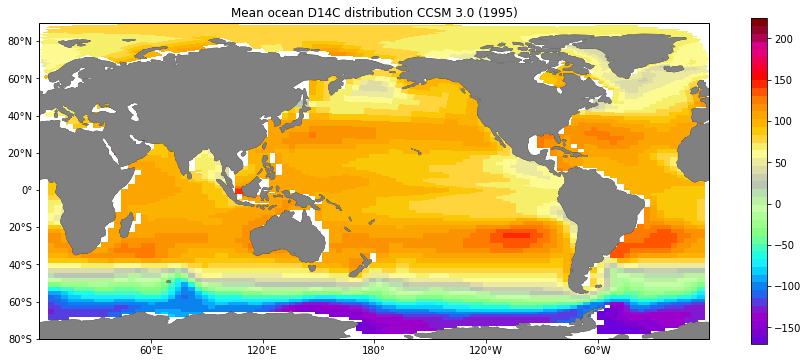

In [89]:
plot_D14C_field(D14C_hist, 1995, 0, c_min = -170, c_max = 225)

## 3. Ocean bomb-$^{14}$C inventory

Calculating the bomb-inventory.

In [117]:
# Load files for air-sea and sea-air fluxes
airseaf = np.load("airseaf")
seaairf = np.load("seaairf")

# Load CCSM grid area file
cell_area = np.load("cell_area") #In units rad^-2
cell_area *= (6371e3)**2  #Multiply by Earth's radius to get area in m^-2

# Load historical atmospheric D14C observation files 
D14C_atm = pd.read_csv('TableS1_170717.csv', sep=',').drop(columns=["Date"])

In [112]:
def inventory(data):
    '''
    Returns the bomb-14C inventory calculated from a model's D14C data
    
    Parameters:
    ------------
        data: numpy.ma.core.MaskedArray
            Masked Array containing the D14C values
    Returns:
    ------------        
        inv_f: numpy.ndarray
            Array containing the bomb-14C inventory value per year
    '''
    net14C_flux = np.ma.empty_like(data[:,0,:,:]) # Extract surface layer

    for yr_ind in range(data.shape[0]):
        for lat_ind in range(data.shape[2]):
            for lon_ind in range(data.shape[3]):
                if np.ma.is_masked(data[yr_ind, 0, lat_ind, lon_ind]):
                    continue
                else:
                    # Separate into latitude bands to extract atm D14C values
                    lat_point = lat_gridc[lat_ind, lon_ind]
                    if lat_point < -30: # -90 to -30, SH
                        D14C_a = D14C_atm["SH_D14co2_(per mil)"].iloc[yr_ind+100]
                    elif lat_point < 30: # -30 to 30, Tropics
                        D14C_a = D14C_atm["Tropics_D14co2_(per mil)"].iloc[yr_ind+100]
                    else: # 30 to 90, NH
                        D14C_a = D14C_atm["NH_D14co2_(per mil)"].iloc[yr_ind+100]
                    net14C_flux[yr_ind, lat_ind, lon_ind] = (airseaf[yr_ind, lat_ind, lon_ind] * (D14C_a/1000 + 1) - seaairf[yr_ind, lat_ind, lon_ind] * (data[yr_ind, 0, lat_ind, lon_ind]/1000+1)) * 1.17e-12

    # Bomb influx per year is the flux minus the 1950 flux. 
    bomb14C_flux = np.ma.empty_like(net14C_flux)
    bomb14C_flux[:,:,:] = net14C_flux[:,:,:] - net14C_flux[0,:,:]
    
    # Cumulatively sum the bomb-14C flux per year 
    cum_bomb14C_flux = np.ma.empty_like(bomb14C_flux)
    for i in range(1, cum_bomb14C_flux.shape[0]):
        cum_bomb14C_flux[i,:,:] = cum_bomb14C_flux[i-1 ,:,:] + bomb14C_flux[i,:,:]*24*(60**2)*365 # Convert cm/s to cm/year
        
    # Calculative inventory by weighing each grid by the area.
    inv = np.zeros(cum_bomb14C_flux.shape[0])

    for i in range(len(inv)):
        inv[i] = np.sum(cum_bomb14C_flux[i,:,:]*cell_area[:,:])

    inv_f = inv*10**-2*6.02e23*1e-3/1e26
    
    return inv_f

In [113]:
#Calculate the CCSM inventory
inv_before = inventory(D14C_hist)

In [114]:
inv_before 

array([0.00000000e+00, 3.31756578e-02, 1.05970272e-01, 2.25909413e-01,
       4.53552192e-01, 1.10563069e+00, 2.74386153e+00, 5.31292060e+00,
       9.65382700e+00, 1.63008447e+01, 2.35805888e+01, 3.09471760e+01,
       3.98997168e+01, 5.56108065e+01, 7.70923443e+01, 9.93880299e+01,
       1.19820046e+02, 1.38067488e+02, 1.54421764e+02, 1.69823960e+02,
       1.84354165e+02, 1.97951437e+02, 2.10399112e+02, 2.21429207e+02,
       2.31438398e+02, 2.40688295e+02, 2.49050723e+02, 2.56596150e+02,
       2.63749460e+02, 2.70059651e+02, 2.75587957e+02, 2.80611214e+02,
       2.85147331e+02, 2.89166049e+02, 2.92754540e+02, 2.96181458e+02,
       2.99339501e+02, 3.02255053e+02, 3.05040669e+02, 3.07455435e+02,
       3.09566450e+02, 3.11443237e+02, 3.13110877e+02, 3.14658275e+02,
       3.16056608e+02, 3.17346647e+02, 3.18549646e+02, 3.19578962e+02,
       3.20550118e+02, 3.21411763e+02, 3.22126803e+02, 3.22716507e+02,
       3.23195522e+02, 3.23587932e+02, 3.23834631e+02, 3.24015394e+02,
      

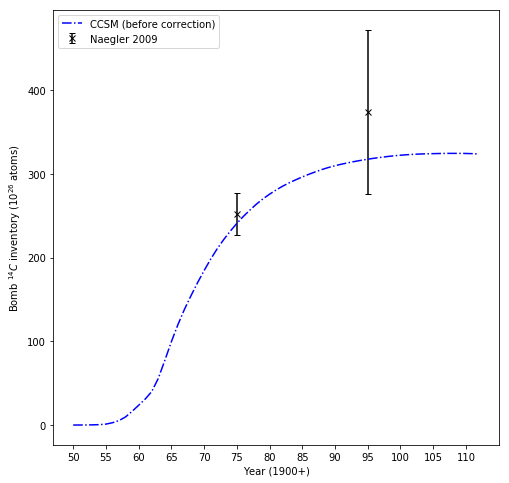

In [110]:
# Plot inventories
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(np.arange(50, 113), inv_before, 'b-.', label="CCSM (before correction)")

# Reference values
ax.errorbar([75, 95], [252, 374], yerr=[25, 98], fmt='kx', capsize=3, label="Naegler 2009")
ax.set_xlabel("Year (1900+)")
ax.set_ylabel(r"Bomb $^{14}C$ inventory ($10^{26}$ atoms)")
ax.set_xticks(np.arange(50, 115, 5))
ax.legend()

## 4. K-Means clustering

In [43]:
from sklearn.cluster import KMeans

Function for assigning the clusters back into the original OGCM grid space. 

In [44]:
def assign_clusters(data, rs_fil_data, cluster_lab):
    '''
    Returns an array in the original dimensions of the OGCM output (but single depth) with the clusters assigned to each grid-cell
    
    Parameters:
    ------------
        data: numpy.ma.core.MaskedArray
            Masked Array containing the D14C values
        rs_fil_data: numpy.ndarray
            Array containing only the valid (non-masked) D14C values
        cluster_lab: numpy.ndarray
            Array containing the cluster assignments for each valid (non-masked) grid, i.e. not in the original OGCM grid space.  
    Returns:
    ------------        
        cluster_map: numpy.ma.core.MaskedArray
            Masked Array containing the cluster assignments (as integers) for every grid-cell in the original model dimension. 
    '''
    #2D array of lat/lon grid cells with the value being their assigned cluster (instead of D14C value)
    cluster_map = np.zeros((116,100)) #Initialise with the D14C masked array first 
    
    for k in range(len(cluster_lab)):
        val_set = []
        curr_val = rs_fil_data[k]
        #locate positiong of curr_val in the filtered, reshaped list and the original array 
        if curr_val not in val_set: #Check if the cluster values from this D14C value have been assigned already 

            coord = np.where(rs_fil_data == curr_val)[0]
            arraycoord = np.where(data == curr_val)
            #print(arraycoord)
            multi = len(coord)
            #Go through all the occurrences of this D14C value and assign the corresponding cluster number 
            for i in range(multi):
                clust = cluster_lab[coord][i]
                #lat and lon grid indexes to assign this cluster value to 
                lt = arraycoord[0][i]
                ln = arraycoord[1][i]
                cluster_map[lt][ln] = clust
            val_set.append(curr_val)
        else:
            pass 
    return cluster_map 

Manually created colourmap for plotting the D14C clusters. (As distinctly as possible). 

In [45]:
import matplotlib.patches as mpatches
clustclr = ['b','r','g','c','yellow','m','lawngreen', 'orange', 'powderblue', 'brown', 'lightcoral', 'olive', 'rosybrown', 'papayawhip', 'crimson', 'navy', 'darkmagenta', 'darkgreen', 'linen', 'steelblue' ]

Matrix standardisation function and function for adding a feature to the cluster matrix $\mathcal{X}$.

In [46]:
def stand(data):
    stand_data = [0 for i in range(len(data))]
    for x in range(len(data)):
        stand_data[x] = 2*(data[x]-np.min(data))/(np.max(data)-np.min(data))-1
    return stand_data

def add_feature(data, i, prop):
    feat = 0
    if prop == "max":
        feat = np.max(data[i])
    elif prop == "min":
        feat = np.min(data[i])
    elif prop == "init":
        feat = data[i][0]
    elif prop == "end":
        feat = data[i][-1]
    elif prop == "argmax":
        feat = np.argmax(data[i])
    return feat

In [51]:
def Kcluster_props_plot1(mat,yrst, yrend, depth, K, init, n_init, epoch, algo, seed, features=None, plot= False):
    '''
    K-means clustering via time-series or feature clustering.
    
    Params:
    ---------------------------------
        mat: str
            Cluster matrix method, "time-series" or "feature". If "feature" chosen, the kwarg features must be assigned a value 
        yrst: int
            Start year of data to cluster 
        yrend: int
            End year of data to cluster 
        depth: int
            Depth layer data to cluster  
        K: int
            Number of clusters 
        init: {‘k-means++’, ‘random’ or an ndarray}
            Method for initialization, defaults to ‘k-means++’:
        n_init : int, default: 10
            Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
        epoch: int
            Maximum number of iterations of the k-means algorithm for a single run.
        algo: “auto”, “full” or “elkan”, default=”auto”
            K-means algorithm to use. 
        seed:  int, RandomState instance or None (default)
            Determines random number generation for centroid initialization. Use an int to make the randomness deterministic
        features: list
            List of features to cluster, ['max', 'min'] for e.g., choose from the features in the add_feature function 
        plot: True or False:
            Determines whether to plot the resulting clusters 

    Returns:
    ---------------------------------
        cluster_map: numpy.ma.core.MaskedArray
                Masked Array containing the cluster assignments (as integers) for every grid-cell in the original model dimension. 
    '''
    #Prepare training data
    yrst_index = yrst - 1950
    dur = yrend - yrst
    #Select the required years and depth subset from the entire D14C data
    D14C = D14C_hist[yrst_index:yrst_index+dur+1,depth,:,:]
    D14C_rs = D14C.reshape(dur+1,11600)
    D14C_rs_fil = D14C_rs.data[D14C_rs.data < 10**5].reshape(dur+1,7870)
    D14C_rs_fil = np.transpose(D14C_rs_fil)
    
    #Create array of just the first year's data for cluster assignment 
    D14C0 = D14C_hist[yrst_index,depth,:,:]
    D14C_rs0 = D14C0.reshape(11600)
    D14C_rs_fil0 = D14C_rs0.data[D14C_rs0.data < 10**5]
    
    #Create the cluster matrix X depending on the matrix used (time series or feature)
    if mat == "time-series":
        X = D14C_rs_fil
    elif mat == "feature":
        X = np.zeros((7870, len(features)))
        for i in range(len(X)):
            for k in range(len(X[0])):
                X[i][k] = add_feature(D14C_rs_fil, i, features[k])

        #Normalise each property (column) of the matrix X (i.e. data over range [-1,1])
        X = np.transpose(X)
        for j in range(len(X)):
            X[j] = stand(X[j])
        X = np.transpose(X)
    
    #K-means clustering     
    kmeans = KMeans(n_clusters=K, init = init, n_init = n_init, max_iter = epoch, algorithm = algo, random_state= seed).fit(X)
    
    centroids = kmeans.cluster_centers_
    
    #Assign each grid cell its respective 
    cluster_map = assign_clusters(D14C0, D14C_rs_fil0, kmeans.labels_)
    #global cluster_map_ma
    cluster_map_ma = np.ma.masked_array(data=cluster_map, mask= np.zeros((116,100)))
    
    #Mask the cluster map in the same manner as D14C
    for x in range(len(D14C0)):
        for y in range(len(D14C0[0])):
            if np.ma.is_masked(D14C0[x][y]):
                cluster_map_ma[x][y] = np.ma.masked
    
    if plot == True:
        #Now plotting the global D14C cluster distribution 

        #Filling in the discontinuity between the first and last longitude grid points 
        #For now, I define the pcolor grid vertices with lat_grid/ lon_grid which are the grid vertex coordinates
        lat_fill = np.column_stack((lat_grid[:,-1],lat_grid))
        lon_fill = np.column_stack((lon_grid[:,-1],lon_grid))
        cluster_map_ma_fill = np.ma.column_stack((cluster_map_ma[:,-1],cluster_map_ma[:,:-1]))

        #Masking of the data points at grid cells on the 0/360 longitude boundary 
        PLOTy = cluster_map_ma_fill

        for x in range(1,len(lon_fill)):
            for i in range(1,len(lon_fill[0])):
                if abs(lon_fill[x][i-1] - lon_fill[x][i]) > 100:
                    PLOTy[x][i-1] = np.ma.masked
                    PLOTy[x][i] = np.ma.masked
                if abs(lon_fill[x][i] - lon_fill[x-1][i]) > 40:
                    PLOTy[x-1][i] = np.ma.masked
                    PLOTy[x][i] = np.ma.masked
                if abs(lon_fill[x][i] - lon_fill[x-1][i-1]) > 40:
                    PLOTy[x-1][i-1] = np.ma.masked
                    PLOTy[x][i] = np.ma.masked

        #Plot the global ocean D14C distribution 
        fig, ax = plt.subplots(1, 1, figsize = (10,10))
        ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
        ax.coastlines()
        ax.add_feature(cfeature.LAND,facecolor='grey', zorder = 1)

        CS = ax.pcolor(lon_fill, lat_fill, PLOTy, cmap=LinearSegmentedColormap.from_list(
                cmap_name, clustclr[:K], N=K), transform=ccrs.PlateCarree())

        ax.set_xticks(np.arange(60, 360, 60), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(-80, 100, 20), crs=ccrs.PlateCarree())

        lon_formatter = LongitudeFormatter()
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        ax.set_title(f'Clusters of D14C CCSM 3.0 ({yrst}-{yrend})') 

        #fig.colorbar(CS, shrink=.4) #I manually shrinked the colourbar here. For some reason (ax = ax) doesn't work. Trying solutions with the 
                                    #divider method throws "map_projection" error. 

        ax.legend([mpatches.Patch(color=b) for b in clustclr[:K]], [i for i in range(1,K+1)], loc="upper left", bbox_to_anchor=(1,1),title="Clusters")    
    
    return cluster_map_ma#, centroids

Time-series clustering on the CCSM data (1950-2012), $K=10$.

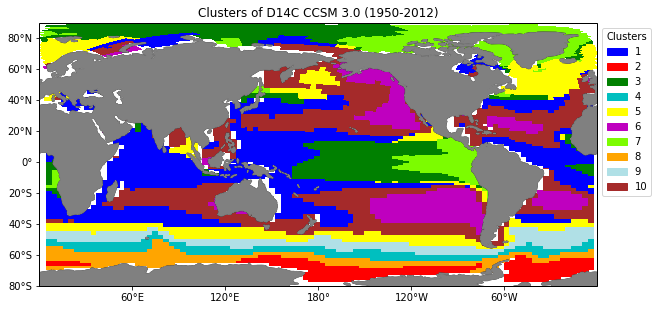

In [52]:
prop_map_all = Kcluster_props_plot1("time-series", 1950, 2012, 0, 10, 'k-means++', 10, 300, "elkan", 1, plot=True) #1 feature/ property Max

In [58]:
def plot_cluster_time(cl_map, cl):
    ''' 
    Params:
        cl_map: numpy.ma.core.MaskedArray
            Masked Array containing the cluster assignments (as integers) for every grid-cell in the original model dimension. 
        cl: int
            Selected cluster number for which the time series are plotted 
    '''
    fig, ax = plt.subplots(cl, 1, figsize = (4,int(2.5*cl)))
    
    for x in range(cl):
        
        lat_, lon_ = np.where(cl_map == x)

        # South Hemisphere
        #fig, ax = plt.subplots(figsize = (10,5))
        ax[x].set_title(f"Cluster {x+1}")
        ax[x].set_xlabel("Year")
        ax[x].set_ylabel(r"$\Delta^{14}$C")


        for (lat_ind,lon_ind) in zip(lat_, lon_):
            lat_point = lat_grid[lat_ind, lon_ind]
            
            ax[x].plot(np.arange(1950,2013), D14C_hist[:,0,lat_ind,lon_ind], label = "lat = {0:.1f}, lon = {1:.1f}".format(lat_grid[lat_ind, lon_ind], lon_grid[lat_ind, lon_ind]))
            
    fig.tight_layout()
    #ax.legend()
    #ax1.legend()

Plot the D14C time series in each cluster to check for similarity.

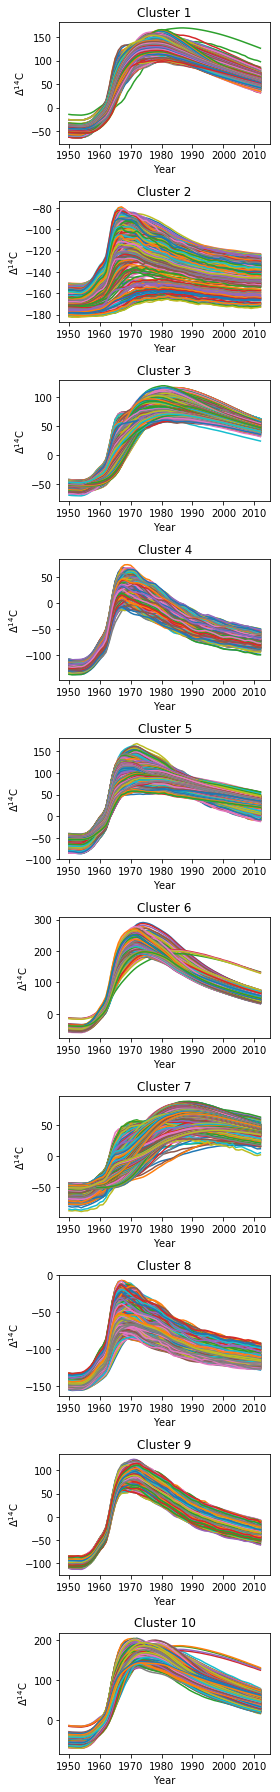

In [59]:
plot_cluster_time(prop_map_all, 10)

## 5. Fuzzy Clustering 

Some documentation: https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.cluster.html <br>

Note a difference in how the data to be clustered is shape for this function compared to sklearn kmeans:

    data : 2d array, size (S, N)

    Data to be clustered. N is the number of data sets; S is the number of features within each sample vector. 

Need a new cluster assigning function because instead of assigning a specific cluster to each grid cell I instead assign its corresponding vector from the fuzzy c-partitioned matrix $U$ instead. When visualising the assigned cluster would then be the one with the highest similarity score. 

In [23]:
def assign_fuzz_clusters(data, rs_fil_data, u_mat, K):
    '''
    Returns an array in the original dimensions of the OGCM output (but single depth) with the clusters assigned to each grid-cell
    
    Parameters:
    ------------
        data: numpy.ma.core.MaskedArray
            Masked Array containing the D14C values
        rs_fil_data: numpy.ndarray
            Array containing only the valid (non-masked) D14C values
        u_mat: numpy.ndarray
            The FCM U-matrix 
        K: int
            Number of clusters  
    Returns:
    ------------        
        cluster_map: numpy.ma.core.MaskedArray
            Masked Array containing the cluster assignments (as integers) for every grid-cell in the original model dimension.
    '''
    #2D array of lat/lon grid cells with the value being their assigned cluster (instead of D14C value)
    cluster_map = np.zeros((116,100,K)) #Initialise with the D14C masked array first 
    
    for k in range(len(u_mat[0])):
        val_set = []
        curr_val = rs_fil_data[k]
        #locate positiong of curr_val in the filtered, reshaped list and the original array 

        

        if curr_val not in val_set: #Check if the cluster values from this D14C value have been assigned already 

            coord = np.where(rs_fil_data == curr_val)[0]
            arraycoord = np.where(data == curr_val)
            #print(arraycoord)
            multi = len(coord)
            #Go through all the occurrences of this D14C value and assign the corresponding cluster number 
            for i in range(multi):
                clust = np.transpose(u_mat)[coord][i]
                #lat and lon grid indexes to assign this cluster value to 
                lt = arraycoord[0][i]
                ln = arraycoord[1][i]
                cluster_map[lt][ln] = clust
            val_set.append(curr_val)
        else:
            pass 
    return cluster_map 

This is a 116x100x10 array where each row entry is a vector containing that grid cell's similarity values w.r.t each of the 10 clusters. 

** Fuzzy C-means clustering function **

In [63]:
def FCM_time_plot(mat, yrst, yrend, depth, K, M, features = None, plot = False):
    '''
    Fuzzy C-means clustering of D14C data by either Time series or time series features {max, min, init, end, argmax}
    
    Params:
    ----------
    mat: str
        Method/ matrix to cluster, either "time series" or "feature". If "feature" select the arg feature must not be None 
    yrst: int
        Starting year of data to cluster
    yrend: int
        End year of data to cluster
    depth: int
        Depth of ocean data
    K: int
        Number of clusters
    M: float
        Fuzzy parameter. Larger M will give larger fuzziness. 
    features: list
        List of features to include in the cluster matrix X for feature matrix clustering. Format as ['max', 'end'] for e.g. 
    plot: bool
        Denote whether to plot the clusters or not.
    
    Returns
    ----------
    cluster_map_vis: numpy.ma.core.MaskedArray
        Spatial array of the D14C model grid with each grid cell's cluster numbers
    cluster_map_ma: numpy.ma.core.MaskedArray
        Spatial array of the D14C model grid with each grid cell's cluster membership values 
    '''
    #Prepare training data
    yrst_index = yrst - 1950
    dur = yrend - yrst
    #Select the required years and depth subset from the entire D14C data
    D14C = D14C_hist[yrst_index:yrst_index+dur+1,depth,:,:]
    D14C_rs = D14C.reshape(dur+1,11600)
    D14C_rs_fil = D14C_rs.data[D14C_rs.data < 10**5].reshape(dur+1,7870)
    #D14C_rs_fil = np.transpose(D14C_rs_fil)
    
    #Create array of just the first year's data for cluster assignment 
    D14C0 = D14C_hist[yrst_index,depth,:,:]
    D14C_rs0 = D14C0.reshape(11600)
    D14C_rs_fil0 = D14C_rs0.data[D14C_rs0.data < 10**5]
    
    #Create the cluster matrix X depending on the matrix used (time series or feature)
    if mat == "time-series":
        X = D14C_rs_fil
    elif mat == "feature":
        #The properties matrix X with (for now) x columns representing x features of the grid cell D14C behaviour (max, min, init, end, time of max D14C)
        D14C_rs_fil = np.transpose(D14C_rs_fil)
        X = np.zeros((7870, len(features)))
        for i in range(len(X)):
            for k in range(len(X[0])):
                X[i][k] = add_feature(D14C_rs_fil, i, features[k])
    
    
        #Normalise each property (column) of the matrix X (i.e. data over range [-1,1])
        X = np.transpose(X)
        for j in range(len(X)):
            X[j] = stand(X[j])
        
        
    
    #Fuzzy C-means clustering 
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X, K, M, error=0.0001, maxiter=1000, init=None, seed = 0)
    
    #Assign each grid cell its respective cluster similarity array 
    cluster_map = assign_fuzz_clusters(D14C0, D14C_rs_fil0, u, K)
    cluster_map_ma = np.ma.masked_array(data=cluster_map, mask= np.zeros((116,100,K)))
    
    #Separately store an array of only the max similarity score (i.e just an assigned cluster number like in kmeans), just for plotting purposes 
    #cluster_map_vis = np.argmax(cluster_map_ma, axis=2)
    cluster_map_vis = np.ma.masked_array(data=np.argmax(cluster_map_ma, axis=2), mask= np.zeros((116,100)))
    
    
    #Mask the cluster map in the same manner as D14C
    for x in range(len(D14C0)):
        for y in range(len(D14C0[0])):
            if np.ma.is_masked(D14C0[x][y]):
                cluster_map_ma[x][y] = np.ma.masked
                cluster_map_vis[x][y] = np.ma.masked 
                
    cluster_map_vis = cluster_map_vis.astype(float)      
    
    if plot == True:
        #Now plotting the global D14C cluster distribution 
        #Filling it the discontinuity between the first and last longitude grid points 
        #For now, I define the pcolor grid vertices with lat_grid/ lon_grid which are the grid vertex coordinates
        lat_fill = np.column_stack((lat_grid[:,-1],lat_grid))
        lon_fill = np.column_stack((lon_grid[:,-1],lon_grid))
        cluster_map_ma_fill = np.ma.column_stack((cluster_map_vis[:,-1],cluster_map_vis[:,:-1]))

        #Masking of the data points at grid cells on the 0/360 longitude boundary 
        PLOTy = cluster_map_ma_fill

        for x in range(1,len(lon_fill)):
            for i in range(1,len(lon_fill[0])):
                if abs(lon_fill[x][i-1] - lon_fill[x][i]) > 100:
                    PLOTy[x][i-1] = np.ma.masked
                    PLOTy[x][i] = np.ma.masked
                if abs(lon_fill[x][i] - lon_fill[x-1][i]) > 40:
                    PLOTy[x-1][i] = np.ma.masked
                    PLOTy[x][i] = np.ma.masked
                if abs(lon_fill[x][i] - lon_fill[x-1][i-1]) > 40:
                    PLOTy[x-1][i-1] = np.ma.masked
                    PLOTy[x][i] = np.ma.masked

        #Plot the global ocean D14C distribution 
        fig, ax = plt.subplots(1, 1, figsize = (10,10))
        ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
        ax.coastlines()
        ax.add_feature(cfeature.LAND,facecolor='grey', zorder = 1)

        CS = ax.pcolor(lon_fill, lat_fill, PLOTy, cmap=LinearSegmentedColormap.from_list(
                cmap_name, clustclr[:K], N=K), transform=ccrs.PlateCarree())

        ax.set_xticks(np.arange(60, 360, 60), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(-80, 100, 20), crs=ccrs.PlateCarree())

        lon_formatter = LongitudeFormatter()
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        ax.set_title(f'Clusters of D14C CCSM 3.0 ({yrst}-{yrend})') 

        #fig.colorbar(CS, shrink=.4) #I manually shrinked the colourbar here. For some reason (ax = ax) doesn't work. Trying solutions with the 
                                    #divider method throws "map_projection" error. 

        ax.legend([mpatches.Patch(color=b) for b in clustclr[:K]], [i for i in range(1,K+1)], loc="upper left", bbox_to_anchor=(1,1),title="Clusters")    
    return cluster_map_ma, cluster_map_vis
    

FCM time-series clustering on CCSM-data (1950-2012), $K=10, m=1.6$.

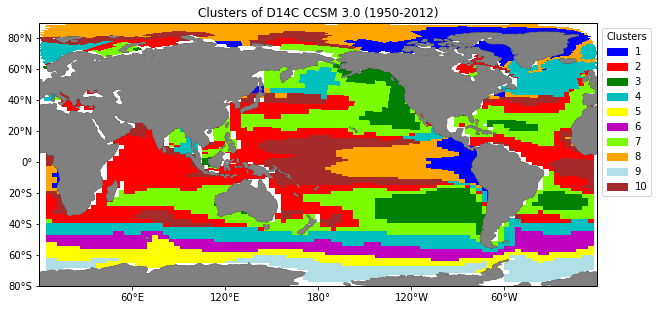

In [64]:
fcm_map_u_all, fcm_map_all = FCM_time_plot("time-series", 1950, 2012, 0, 10, 1.6, plot = True)

## 6. Loading observations 

Loading the observation data for cluster bias calculation. This observation file has been modified from its original form to include every observation's associated CCSM grid coordinates (via nearest neighbour search). 

In [26]:
# REAL ONES FOR INVENTORY
D14C_comp_real = pd.read_csv('ObsCCSM_new2.csv')
D14C_comp_real.tail()

,Unnamed: 0,index,year_round,lat_round2,lon_round2,depth,D14C,associated_lat,associated_lon,ECCO_value
3819,3819,4951,2012,35.71,292.83,2.878900,67.700000,35.472813,291.424744,69.621918
3820,3820,4952,2012,37.25,307.67,2.977700,53.300000,37.102856,309.176117,62.134148
3821,3821,4953,2012,37.81,291.53,22.529033,68.633333,37.665703,291.565002,63.977005
3822,3822,4954,2012,40.40,307.67,3.572300,50.700000,40.986431,309.317291,42.015671
3823,3823,4955,2012,42.05,308.42,2.976400,57.700000,42.752262,309.401093,33.912422


The next steps average out any duplicates (such as >1 observations being assigned to the same CCSM grid-cell) so that each grid-cell can only have one observation data point per year. 

In [27]:
D14C_comp_real_unique = D14C_comp_real.groupby(['year_round','associated_lat','associated_lon']).mean().reset_index() #Remove duplicates that may have been generated from the regridding procedure

In [30]:
D14C_comp_real_unique = D14C_comp_real_unique.drop(['depth', 'lat_round2', 'lon_round2', 'Unnamed: 0'], axis=1)
D14C_comp_real_unique.tail()

,year_round,associated_lat,associated_lon,index,D14C,ECCO_value
2992,2012,35.472813,291.424744,4951.0,67.700000,69.621918
2993,2012,37.102856,309.176117,4952.0,53.300000,62.134148
2994,2012,37.665703,291.565002,4953.0,68.633333,63.977005
2995,2012,40.986431,309.317291,4954.0,50.700000,42.015671
2996,2012,42.752262,309.401093,4955.0,57.700000,33.912422


In [31]:
D14C_comp_real_unique.columns = ['year_round', 'mod_lat','mod_lon', "index", "D14C", "mod_D14C"] #where D14C is the real observation value 

In [124]:
D14C_comp_real_unique.head()

,year_round,mod_lat,mod_lon,index,D14C,mod_D14C
0,1950,-21.800896,154.100006,935.0,-52.200000,-51.394344
1,1950,-21.800896,200.899994,936.0,-49.375000,-48.328461
2,1950,-9.098413,161.300003,938.5,-53.137500,-55.417179
3,1950,-0.300148,164.899994,941.0,-60.333333,-53.455173
4,1951,-21.800896,154.100006,944.0,-55.400000,-52.089573


In [32]:
mod_lon_real = np.array(D14C_comp_real_unique['mod_lon'])
mod_lat_real = np.array(D14C_comp_real_unique['mod_lat']) #lat (in CCSM grid) of real observation
mod_D14C_real = np.array(D14C_comp_real_unique['D14C'])  #real observation

Determining the suitable number of clusters by counting the number of observations per cluster. 

In [33]:
def count_clust_obs(cl_map, D14C_obsv):
    ''' 
    Params:
    cl_map: lat x lon array of each grid cell's assigned clusters 
    cl: Selected cluster number for which the time series and histograms are plotted 
    '''
    global clust_count    
    clust_count = [0 for x in range(int(np.max(cl_map))+1)]
    
    mod_lon = np.array(D14C_obsv['mod_lon'])
    mod_lat = np.array(D14C_obsv['mod_lat'])
    #Now loop through the mod_lat/lon, find the associated cluster of that point and count how many observ in 
    #each cluster 
    
    for (lat, lon) in zip(mod_lat, mod_lon):
        
        lat_ind, lon_ind = np.where((lat_gridc == lat) & (lon_gridc == lon))
        if type(cl_map[lat_ind[0], lon_ind[0]]) == np.float64:
            c_num = int(cl_map[lat_ind[0], lon_ind[0]])
            clust_count[c_num] += 1
        else:
            pass
    
    return clust_count

In [65]:
count_clust_obs(fcm_map_all, D14C_comp_real_unique)

[81, 681, 300, 334, 118, 99, 688, 185, 69, 442]

In [142]:
type(D14C_comp_real_unique)

pandas.core.frame.DataFrame

## 7. Computing the model-observation biases

Visualise the clustered D14C time series against the observations within the respective clusters. 

In [66]:
from matplotlib.collections import LineCollection

def plot_compare(cl_map, D14C_obsv):
    ''' 
    Params:
    -------------------------------------
        cl_map: numpy.ma.core.MaskedArray
            Masked Array containing the cluster assignments (as integers) for every grid-cell in the original model dimension. 
        D14C_obsv: pandas.core.frame.DataFrame
            Dataframe containing the unique D14C observations
    Returns:
    -------------------------------------
        time: list
            list containing the time data per cluster for each D14C obs value 
        D14C_val: list 
            list containing the D14C obs value per cluster
    '''
    time = [[] for x in range(int(np.max(cl_map))+1)] 
    D14C_val = [[] for y in range(int(np.max(cl_map))+1)] 
    mod_lon = np.array(D14C_obsv['mod_lon'])
    mod_lat = np.array(D14C_obsv['mod_lat'])
    
    indx = 0
    for (lat, lon) in zip(mod_lat, mod_lon):
        
        lat_ind, lon_ind = np.where((lat_gridc == lat) & (lon_gridc == lon))
        if type(cl_map[lat_ind[0], lon_ind[0]]) == np.float64:
            c_num = int(cl_map[lat_ind[0], lon_ind[0]])
            time[c_num].append(list(D14C_obsv['year_round'])[indx])
            D14C_val[c_num].append(list(D14C_obsv['D14C'])[indx])
        else:
            pass
        indx += 1
        
    fig, ax = plt.subplots(int(np.max(cl_map)+1), 1, figsize = (5,int(3*int(np.max(cl_map)+1))))    
        
    for i in range(int(np.max(cl_map)+1)):
        #Set up and label subplot axes
        ax[i].set_xlabel("Year")
        ax[i].set_ylabel(r"$\Delta^{14}$C")
        ax[i].set_title(f"Cluster {i+1}")
        
        lat_, lon_ = np.where(cl_map == i)
        line = []
        for (lat_ind,lon_ind) in zip(lat_, lon_):
            lat_point = lat_grid[lat_ind, lon_ind]
            
            #Add grid cells within cluster i into a line collection containing all other cells in that cluster and hemisphere 
            line.append(list(zip(np.arange(1950,2013), D14C_hist[:,0,lat_ind,lon_ind])))
        line = LineCollection(line, label='CCSM 3.0')
        ax[i].add_collection(line)
        ax[i].plot(time[i], D14C_val[i], 'rx', label = 'ECCOv4 Obs')
        ax[i].legend()
    fig.tight_layout()
    
    return time, D14C_val

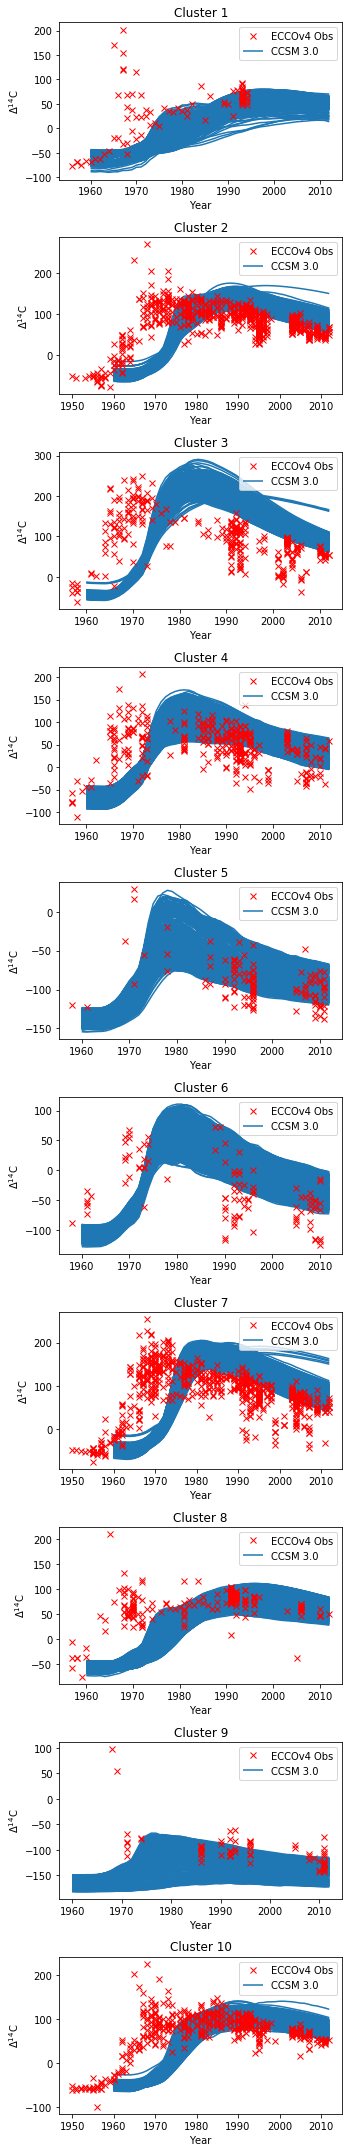

In [67]:
fyrs, fvals = plot_compare(fcm_map_all, D14C_comp_real_unique)

Compute and visualise the D14C biases for each cluster. 

In [35]:
def plot_bias(cl_map, D14C_obsv, plot = False):
    ''' 
    Params:
    -------------------------------------
        cl_map: numpy.ma.core.MaskedArray
            Masked Array containing the cluster assignments (as integers) for every grid-cell in the original model dimension. 
        D14C_obsv: pandas.core.frame.DataFrame
            Dataframe containing the unique D14C observations
    Returns:
    -------------------------------------
        time: list
            list containing the time data per cluster for each D14C obs value 
        D14C_obs: list 
            list containing the D14C obs value per cluster
        D14C_mod: list 
            list containing the corresponding model D14C value per cluster
        D14C_bias: list 
            list containing the D14C bias values per cluster
    '''
    mod_lon = np.array(D14C_obsv['mod_lon'])
    mod_lat = np.array(D14C_obsv['mod_lat'])
    
    time = [[] for x in range(int(np.max(cl_map)+1))]
    D14C_obs = [[] for x in range(int(np.max(cl_map)+1))] #Observations
    D14C_mod = [[] for x in range(int(np.max(cl_map)+1))] #CCSM Model data for cells corresponding to those with observations 
    D14C_bias = [[] for x in range(int(np.max(cl_map)+1))]

    indx = 0
    for (lat, lon) in zip(mod_lat, mod_lon):
        lat_ind, lon_ind = np.where((lat_gridc == lat) & (lon_gridc == lon))
        if type(cl_map[lat_ind[0], lon_ind[0]]) == np.float64:
            c_num = int(cl_map[lat_ind[0], lon_ind[0]])
            time[c_num].append(list(D14C_obsv['year_round'])[indx])
            #print (indx)
            D14C_obs[c_num].append(list(D14C_obsv['D14C'])[indx])
            D14C_mod[c_num].append(D14C_hist[list(D14C_obsv['year_round'])[indx]-1950,0,lat_ind[0],lon_ind[0]])
            D14C_bias[c_num].append(D14C_hist[list(D14C_obsv['year_round'])[indx]-1950,0,lat_ind[0],lon_ind[0]]-list(D14C_obsv['D14C'])[indx])

        else:
            pass
        indx += 1

    if plot == True:    

        fig, ax = plt.subplots(int(np.max(cl_map)+1), 1, figsize = (5,int(3*int(np.max(cl_map)+1))), squeeze = False)

        for i in range(int(np.max(cl_map)+1)):
            #Set up and label subplot axes
            ax[i][0].set_xlabel("Year")
            ax[i][0].set_ylabel("D14C")
            ax[i][0].set_xlim((1955,2017))
            ax[i][0].set_title(f"D14C (1950-2012) within cluster {i+1}")
            ax[i][0].plot(time[i], D14C_bias[i], 'gx', label = 'CCSM - Observations')
            ax[i][0].plot([1955,2017], [0,0], 'k--')
            ax[i][0].legend()
        fig.tight_layout()
    
    return time, D14C_obs, D14C_mod, D14C_bias

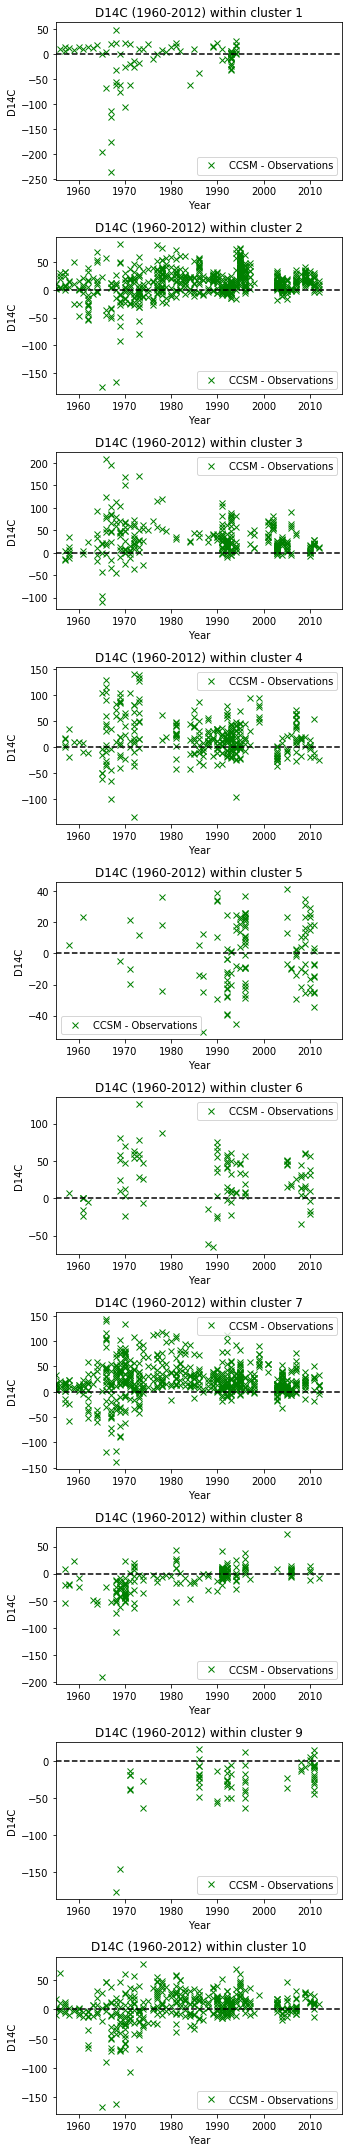

In [69]:
years, obs, mod, bias = plot_bias(fcm_map_all, D14C_comp_real_unique, plot=True)

Polynomial regression fitting

In [70]:
#Simple Poly Function
def polyf(m1,m2,c,x):
     return m1*(x**2)+m2*x+c
    
def polyfit(year_data, bias_data, cl_map, deg):
    """
    Plots data points (xdata, ydata) together with a polynomial regression fitted line with degree deg.
    
    Returns:
    -------
    Array of polynomial fit coefficients 
    """    
    #Initialise array for storing the fitted polynomial coefficients 
    params = [[] for y in range(deg+1)] #last row is the intercept (c)
    
    # Fit for each cluster, then store value to param
    for j in range(int(np.max(cl_map)+1)):
        # Check if the cluster has any observations and handle exceptions -> bias-correction = 0
        if len(year_data[j]) != 0:
            param = np.polyfit(year_data[j], bias_data[j], deg)
            #print (param)
            for power in range(len(param)):
                        params[power].append(param[power])
        else:
            param = np.zeros(deg+1)
            for power in range(len(param)):
                        params[power].append(param[power])
    return params

Visualise the polynomial fitting on the D14C cluster biases. 

In [84]:
def reg_polyfit(year_data, bias_data, cl_map, deg):  
    ''' 
    Params:
    -------------------------------------
        year_data: list
            list containing the time data per cluster for each D14C obs value 
        bias_data: list
            list containing the D14C bias values per cluster
        cl_map: numpy.ma.core.MaskedArray
            Masked Array containing the cluster assignments (as integers) for every grid-cell in the original model dimension. 
        deg: int
            Degree of polynomial fit 
    Returns:
    -------------------------------------
        params: list
            list containing the polynomial fit coefficients 
    '''
    
    #Initialise array for storing the fitted polynomial coefficients 
    params = [[] for y in range(deg+1)] #last row is the intercept (c)
    
    fig, ax = plt.subplots(int(np.max(cl_map)+1), 1, figsize = (5,int(3*int(np.max(cl_map)+1))))
    
    # Fit for each cluster, then store value to param
    for j in range(int(np.max(cl_map)+1)):
        if len(year_data[j]) != 0:
            param = np.polyfit(year_data[j], bias_data[j], deg)
            #print (param)
            for power in range(len(param)):
                        params[power].append(param[power])
            fit = []
            for xpt in np.arange(1950, 2013):
                    val = 0
                    for power in range(len(param)): #Loop through from highest to lowest power and assign the polynomial coefficient 
                        val += param[power]*(xpt**(len(param)-1-power)) # Highest power first
                    fit.append(val)
            ax[j].set_xlabel("Year")
            ax[j].set_ylabel(r"$\Delta^{14}$C")
            ax[j].set_xlim((1945,2017))
            ax[j].set_title(f"Cluster {j+1}")
            ax[j].plot(year_data[j], bias_data[j], 'gx', label = 'CCSM - Observations')
            ax[j].plot([1945,2017], [0,0], 'k--')
            ax[j].plot(np.arange(1950,2013), fit, 'r-.')
            ax[j].plot
    fig.tight_layout()

    return params

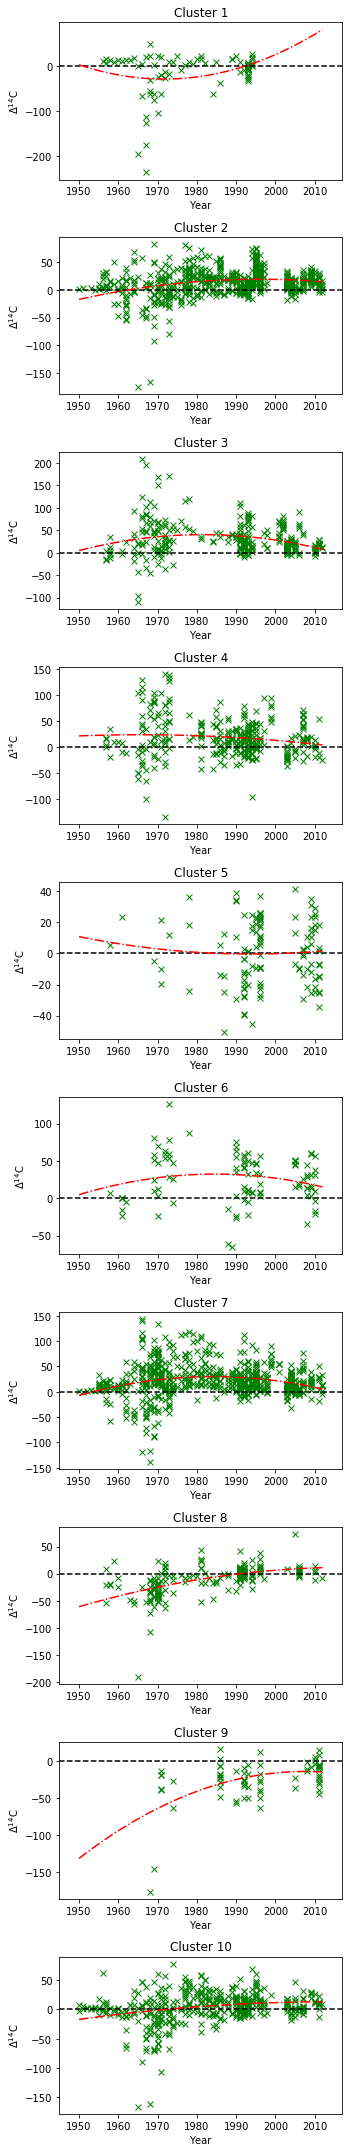

In [85]:
fits = reg_polyfit(years, bias, fcm_map_all , 2)

## 8. Simple Bias Correction Model

A simple version of the bias correction function/ model which only uses one type of bias fitting method (0th/1st/2nd order fit). 

In [86]:
def biascorrect(clust, yr_st, yr_end, D14C_data, year_array, bias_array, cl_map, cl_map_u = None, deg=None):
    """
    Returns the corrected D14C array
    ------------------------------
    Inputs:
        clust: "hard" or "soft"
            Clustering method that was used on the D14C data
        yr_st: int
            Starting year
        yr_end: int
            Ending year
        D14C_data: numpy.ma.core.MaskedArray
            D14C model data to be bias corrected 
        year_array: list
            list containing the time data per cluster for each D14C obs value 
        bias_array: list
            list containing the D14C bias values per cluster
        cl_map: numpy.ma.core.MaskedArray
            Spatial array of the D14C model grid with each grid cell's cluster numbers
        cl_map_u: numpy.ma.core.MaskedArray
            Spatial array of the D14C model grid with each grid cell's cluster membership values 
        deg: int
            Degree of fit 
    ------------------------------
    Returns:
        new_data: numpy.ma.core.MaskedArray
            Masked array of bias-corrected D14C data 
    """
    new_data = np.zeros_like(D14C_data)
    correction = np.zeros_like(D14C_data[:,0,:,:])
    #Obtain the polynomial fit coefficients 
    poly_params = polyfit(year_array, bias_array, cl_map, deg)   
    
    if clust == "hard":
        for i in range(len(year_array)): #loop thru clusters
            for yr in range(yr_end-yr_st+1):
                lat_ind, lon_ind = np.where(cl_map == i)
                correction[yr, lat_ind, lon_ind]
                for dg in range(deg+1):
                    correction[yr, lat_ind, lon_ind] += poly_params[-dg-1][i]*((yr+yr_st)**(dg))  # Polyfit
            new_data[:,0,:,:] = D14C_hist[:,0,:,:] - correction[:,:,:]
            
    elif clust == "soft":
        for i in range(len(year_array)): #loop thru clusters
            for yr in range(yr_end-yr_st+1):
                for dg in range(deg+1):
                    correction[yr, :, :] += poly_params[-dg-1][i]*((yr+yr_st)**(dg))*cl_map_u[:,:,i]  # Polyfit
            new_data[:,0,:,:] = D14C_hist[:,0,:,:] - correction[:,:,:]
            
    return new_data

In [87]:
corr_fcm_f_poly = biascorrect("soft", 1950, 2012, D14C_hist, years, bias, fcm_map_all, fcm_map_u_all, deg=2) #Polynomial fit (2 degree)

Visualise the bias corrected field.

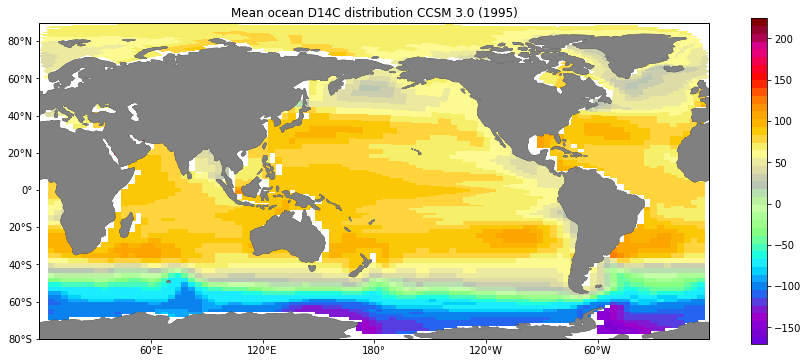

In [88]:
plot_D14C_field(corr_fcm_f_poly, 1995, 0, c_min = -170, c_max = 225)

## 9. Auto-Bias Fit Algorithm 

For inventory correction we use the automated bias algorithm which uses the number of observations in the cluster as a criteria. The function below is only for FCM clustering. 

In [ ]:
def autobiascorrect_f(yr_st, yr_end, D14C_data, year_data, bias_data, cl_map, cl_map_u, plot=True):
    """
    Returns the corrected D14C array
    ------------------------------
    Inputs:
        yr_st: int
            Starting year
        yr_end: int
            Ending year
        D14C_data: numpy.ma.core.MaskedArray
            D14C model data to be bias corrected 
        year_data: list
            list containing the time data per cluster for each D14C obs value 
        bias_data: list
            list containing the D14C bias values per cluster
        cl_map: numpy.ma.core.MaskedArray
            Spatial array of the D14C model grid with each grid cell's cluster numbers
        cl_map_u: numpy.ma.core.MaskedArray
            Spatial array of the D14C model grid with each grid cell's cluster membership values 
        plot: bool
            Decides whether to plot the fitted biases  
    ------------------------------
    Returns:
        new_data: numpy.ma.core.MaskedArray
            Masked array of bias-corrected D14C data 
    """
    if yr_obs_st is None:
        yr_obs_st = yr_st
        
    # Number of clusters to plot
    num_clstr_plot = len(year_data)
    if plot:
        fig, ax = plt.subplots(num_clstr_plot, 1, figsize = (6, 3*num_clstr_plot))
    
    # Stores all parameters
    param = np.zeros([num_clstr_plot, 3])
    # Find fit degree for each cluster
    fitdeg = np.zeros([num_clstr_plot], dtype=int)
    
    no_obs = []
    
    for i in range(num_clstr_plot):
        # Find number of points in each cluster
        no_obs.append(len(year_data[i]))

        if len(year_data[i]) > 0: # something in the cluster to fit
            if no_obs[i] <= 267:  # From eyeballing existing data
                # Average fit
                param[i, -1] = np.average(bias_data[i])
                fitdeg[i] = 0
            else:
                # Quad fit
                param[i, -3:] = np.polyfit(year_data[i], bias_data[i], 2)
                fitdeg[i] = 2
                
    # Find RMSE - Bias correct ### Credits : Gerald
    new_data = np.zeros_like(D14C_data)
    correction = np.zeros_like(D14C_data[:,0,:,:])   

    for i in range(num_clstr_plot): #loop thru clusters
        for yr in range(yr_obs_st-yr_st, yr_end-yr_st+1):  # yr_obs_st-yr_st to account for start of observation after 
            #lat_ind, lon_ind = np.where(cl_map == i)
            for dg in range(fitdeg[i]+1):
                correction[yr, :, :] += param[i, -dg-1]*((yr+yr_st)**(dg))*cl_map_u[:,:,i]  # Polyfit multplied by fuzzyness coefficient
                
    new_data[yr_obs_st-yr_st:,0,:,:] = D14C_data[yr_obs_st-yr_st:,0,:,:] - correction[yr_obs_st-yr_st:,:,:]
    
    print(fitdeg)
    if plot:
        for i in range(num_clstr_plot):
            # Plot optimised configuration
            # Fit a number of points for plotting
            linfit = []
            fitrange = np.arange(yr_st - 2, yr_end + 2)
            for xpt in fitrange:
                val = 0
                for power in range(fitdeg[i] + 1):
                    val += param[i, -1-power]*(xpt**power) # Highest power first
                linfit.append(val)
            # Plot the result
            ax[i].plot(fitrange, linfit, 'r-.', label="Order {0} polynomial fit".format(fitdeg[i]))
            ax[i].set_title(f"Order {fitdeg[i]} fit, cluster {i+1}")

            ax[i].set_xlabel("Year")
            ax[i].set_ylabel(r"$\Delta ^{14}$C Bias")
            ax[i].plot(year_data[i], bias_data[i], 'gx', label=f"{mod_name} - Observations")
            ax[i].plot([yr_st-2, yr_end+2], [0,0], 'k--')
            # Set xticks and xlim to fit year limit for better comparison
            ax[i].set_xticks(np.arange(yr_st, yr_end+10, 10))
            ax[i].set_xlim((yr_st-2, yr_end+2))
            ax[i].legend()

            fig.tight_layout()
    return fitdeg, new_data


[0 2 2 2 0 0 2 0 0 2]


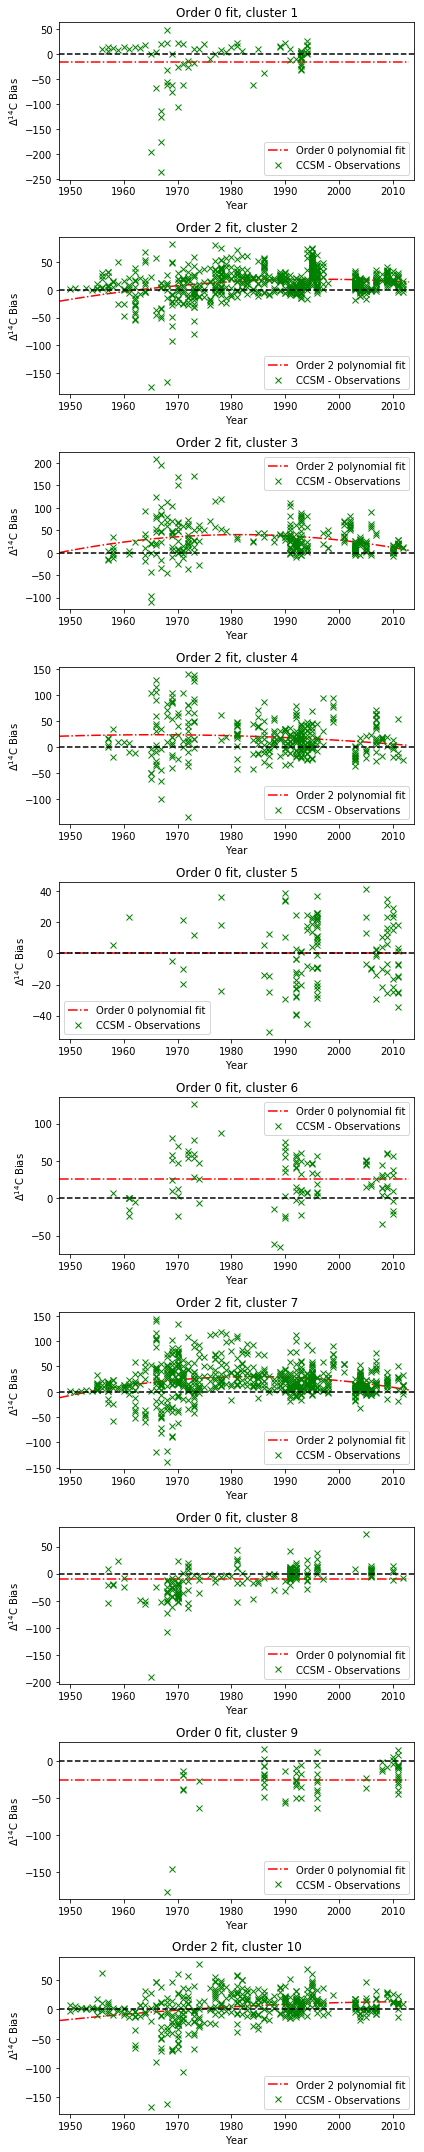

In [111]:
fitdeg_f, D14C_hist_new = autobiascorrect_f(1950, 2012, D14C_hist, years, bias, fcm_map_all, fcm_map_u_all)

## 10. Corrected Inventory

In [115]:
# Calculate the corrected CCSM 14C-inventory
inv_after = inventory(D14C_hist_new)

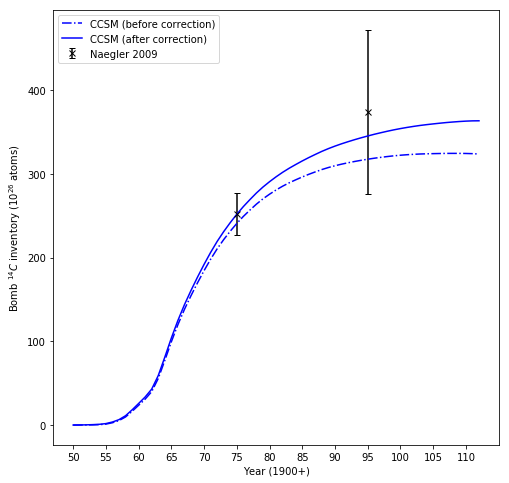

In [116]:
# Plot inventories
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(np.arange(50, 113), inv_before, 'b-.', label="CCSM (before correction)")
ax.plot(np.arange(50, 113), inv_after, 'b-', label="CCSM (after correction)")

# Reference values
ax.errorbar([75, 95], [252, 374], yerr=[25, 98], fmt='kx', capsize=3, label="Naegler 2009")
ax.set_xlabel("Year (1900+)")
ax.set_ylabel(r"Bomb $^{14}C$ inventory ($10^{26}$ atoms)")
ax.set_xticks(np.arange(50, 115, 5))
ax.legend()